# Mission - Classifiez automatiquement des informations

Vous êtes mandaté en tant que Consultant Data Scientist par le département RH de votre client. Il s’agit de l'ESN TechNova Partners, spécialisée dans le conseil en transformation digitale et la vente d’applications en SaaS.
 
Ils font face à un turnover plus élevé que d'habitude et ils souhaitent identifier les causes racines potentielles derrière ces démissions.

### Importation des librairies

In [34]:
# Librairies "classiques"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image, display

# Librairies scikit-learn
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
# Preprocess et modèles
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, auc

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

### On reprend les éléments du notebook de l'étape 2

In [35]:
amelioration_modele = pd.read_csv("../Data/Processed/Projet_4_etape2_clean.csv")

# Partie 4 - Améliorez l'approche de classification

### Recommandation 1 - Avant toute implémentation en code, mettre sur le papier votre approche de modélisation. C’est-à-dire : avec quelle méthodologie je découpe mon jeu de données en apprentissage et test, de quelles métriques d’évaluation je vais avoir besoin etc.

* L'objectif va être de gérer le déséquilibre de notre jeu de données. Nous devons également mieux le stratifier et déterminer le bon seuil de classification avec une courbe PR. Nous sommes dans une situation de déséquilibre alors la courbe ROC n'est pas adaptée.

* Utilisation d'un calcul avec Fbeta pour déterminer le bons seuil à appliquer
* D'après les résultats obtenus par l'étape 3, il semble important de mettre l'accent sur l'amélioration de la métrique Recall qui n'est pas bonne pour chacun des modèles testés.
* D'autant plus dans un sens métier, il est plus judicieux de bien trouver les Faux Négatifs, c'est à dire les salariés qui ont démissionné mais qui sont considérés comme encore dans l'entreprise.
* La métrique Recall et la matrice de confusion vont nous permettre de mieux comprendre les résultats.
* Utilisation également de la moyenne et de l'écart-type pour juger de la performance.
* La métrique Accuracy n'est pas utilisable pour le moment car le déséquilibre fausse la métrique, elle va trouver facilement le Non qui domine notre jeu de données à hauteur de 84%.

Réalisation de différents tests sur 3 modèles :
* Choix du modèle linéaire LogisticRegression
* Choix du modèle non-linéaire XGBoost
* Choix du modèle non-linéaire RandomForest
* Choix du modèle non-linéaire CatBoost

## Création d'une fonction pour appliquer nos modèles

### Application des recommandations suivantes :
* Capitaliser sur les fonctions existantes dans sklearn et privilégier leur utilisation (notamment pour la stratification), à moins que votre méthodologie soit très personnalisée.

* Pendant votre validation croisée, stocker les métriques de chaque itération de Fold dans une liste. Il est très utile de calculer une moyenne ainsi qu’un écart-type sur ces listes. Cela vous donnera une bonne indication sur l’existence ou non d’un overfit, ainsi que la capacité d’un modèle à généraliser son apprentissage à de nouvelles données.

* Utiliser la courbe précision rappel pour déterminer le seuil optimal que doit utiliser votre modèle pour classifier vos observations.

* Si vous êtes déjà à l’aise au niveau du code pour utiliser les différents concepts et librairies, vous pouvez vous intéresser aux fonctionnalités pipelines de sklearn pour mieux organiser vos modélisations.

#### Colonnes à scaler ou déjà encodées


In [3]:
features_a_scaler = [
    'revenu_mensuel','annee_experience_totale','annees_dans_l_entreprise','distance_domicile_travail',
    'annees_depuis_la_derniere_promotion','experience_externe','score_satisfaction',
    'augmentation_par_formation','pee_par_anciennete','niveau_education']
features_encodees = [
    'genre','heure_supplementaires',
    'frequence_deplacement','a_suivi_formation','tranche_age','statut_marital_Celibataire',
    'statut_marital_Divorce','statut_marital_Marie','promotion_recente','poste_AssistantdeDirection',
    'poste_CadreCommercial','poste_Consultant','poste_DirecteurTechnique','poste_Manager',
    'poste_ReprésentantCommercial','poste_RessourcesHumaines','poste_SeniorManager','poste_TechLead']

In [30]:
# Création d'une fonction et pour figer nos conditions
def modelisation(model, amelioration_modele, target_col='a_quitte_l_entreprise', test_size=0.2, random_state=42):
    y = amelioration_modele['a_quitte_l_entreprise']
    X = amelioration_modele.drop(columns='a_quitte_l_entreprise')

# Test en jeu d'apprentissage et de test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state=random_state)
    
 # Demande d'une transformation des colonnes non encodées en scaling et création d'un pipeline
    preprocessor = ColumnTransformer(
        transformers = [
            ('num',StandardScaler(),features_a_scaler),
            ('cat','passthrough',features_encodees)
        ])
    pipeline = Pipeline(steps=[
        ('preproccesor', preprocessor),
        ('model', model)
    ])
# Choix des indicateurs de performance et création de la validation croisée    
    scoring = ['precision','recall','f1','average_precision'] # average_precision = PR AUC
    cv_results = cross_validate(
        pipeline,
        X_train, y_train, # validation croisée que sur l'entraînement
        cv=StratifiedKFold(n_splits=3), #KFold va renvoyer des plis stratifiés
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    print("=== Résultats CV (train vs val) ===")

# Boucle pour calcul de nos indicateurs
    for metric in scoring:
        tr = cv_results[f"train_{metric}"]
        te = cv_results[f"test_{metric}"]
        print(f"{metric:18s}: train {tr.mean():.3f} ± {tr.std():.3f} vs val {te.mean():.3f} ± {te.std():.3f}")

# Entraînement du modèle
    pipeline.fit(X_train,y_train)

# Prédictions sur tain/test et ajout de proba_test
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    proba_test = pipeline.predict_proba(X_test)[:,1] # contenant la probabilité que chaque échantillon soit positif, notre valeur cible.
    
 
# Calcul Average Precision sur Test. C'est la moyenne pondérée des précisions obtenues à chaque seuil
    ap_test = average_precision_score(y_test, proba_test) # proba_test : utilisation des probabilités de Oui ou Non
    print(f"\nPR AUC (Average Precision) — TEST : {ap_test:.3f}")

# Calcul du Fbeta score afin de mettre plus de poids sur le rappel
    precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, proba_test) # création de la PR
    beta = 2 # 2 mets l’accent sur le rappel, sans négliger la précision
    f_beta = (1 + beta**2) * (precision_test * recall_test) / (beta**2 * precision_test + recall_test)
    idx = np.nanargmax(f_beta[:-1])   # -1 car le dernier point n'a pas de seuil/on prend le meilleur résultat
    best_thr = thresholds_test[idx] # prendre le meilleur seuil de probabilité

    print(f"Seuil optimal (F{beta}) : {best_thr:.3f}")
    print(f"Precision={precision_test[idx]:.3f}, Recall={recall_test[idx]:.3f}, F{beta}={f_beta[idx]:.3f}")
   
# Graphique de la courbe Précision Rappel
    plt.plot(recall_test, precision_test, label="Courbe PR")
    plt.scatter(recall_test[idx], precision_test[idx], color="red", zorder=5, label=f"Best F{beta}") # ajout du seuil maximal
    plt.text(0.6, 0.2, f"AP = {ap_test:.3f}", fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Test Set)")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    
# Application du seuil optimal
    seuil_optimal = best_thr
    y_pred_custom = (proba_test >= seuil_optimal).astype(int)

# Génération de 2 classfication report, l'original vs le seuil optimal
    print("=== Classification Report - TEST ===")
    print(classification_report(y_test, y_pred_test, digits=3))
    print("=== Classification Report — TEST avec seuil optimal ===")
    print(classification_report(y_test, y_pred_custom, digits=3))

    return model

#### Résultats pour la régression logistique

=== Résultats CV (train vs val) ===
precision         : train 0.801 ± 0.009 vs val 0.719 ± 0.084
recall            : train 0.376 ± 0.025 vs val 0.348 ± 0.069
f1                : train 0.512 ± 0.025 vs val 0.463 ± 0.060
average_precision : train 0.662 ± 0.016 vs val 0.600 ± 0.048

PR AUC (Average Precision) — TEST : 0.397
Seuil optimal (F2) : 0.226
Precision=0.338, Recall=0.615, F2=0.529


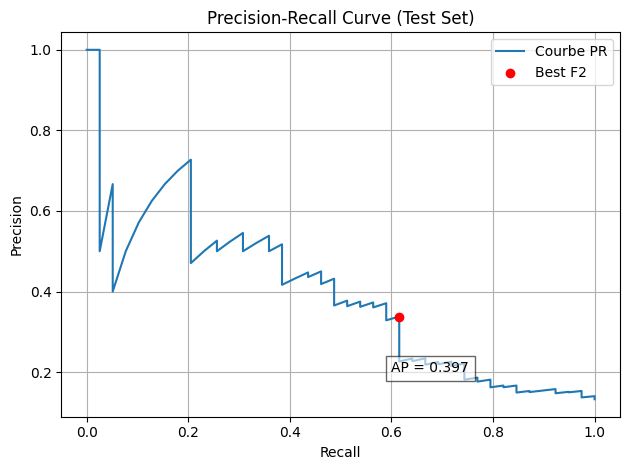

=== Classification Report - TEST ===
              precision    recall  f1-score   support

           0      0.897     0.961     0.928       255
           1      0.524     0.282     0.367        39

    accuracy                          0.871       294
   macro avg      0.711     0.621     0.647       294
weighted avg      0.848     0.871     0.854       294

=== Classification Report — TEST avec seuil optimal ===
              precision    recall  f1-score   support

           0      0.933     0.816     0.870       255
           1      0.338     0.615     0.436        39

    accuracy                          0.789       294
   macro avg      0.635     0.716     0.653       294
weighted avg      0.854     0.789     0.813       294



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [31]:
modelisation(LogisticRegression(), amelioration_modele)

#### Résultats pour le RandomForest

=== Résultats CV (train vs val) ===
precision         : train 1.000 ± 0.000 vs val 0.727 ± 0.120
recall            : train 0.997 ± 0.004 vs val 0.247 ± 0.029
f1                : train 0.999 ± 0.002 vs val 0.363 ± 0.012
average_precision : train 1.000 ± 0.000 vs val 0.555 ± 0.019

PR AUC (Average Precision) — TEST : 0.305
Seuil optimal (F2) : 0.090
Precision=0.185, Recall=0.897, F2=0.507


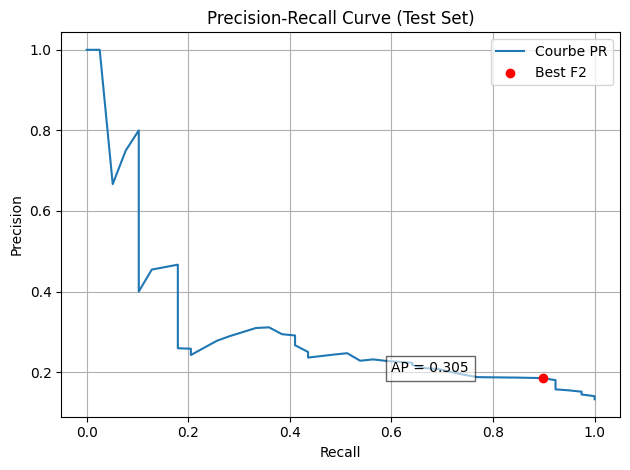

=== Classification Report - TEST ===
              precision    recall  f1-score   support

           0      0.879     0.996     0.934       255
           1      0.800     0.103     0.182        39

    accuracy                          0.878       294
   macro avg      0.839     0.549     0.558       294
weighted avg      0.868     0.878     0.834       294

=== Classification Report — TEST avec seuil optimal ===
              precision    recall  f1-score   support

           0      0.962     0.396     0.561       255
           1      0.185     0.897     0.307        39

    accuracy                          0.463       294
   macro avg      0.574     0.647     0.434       294
weighted avg      0.859     0.463     0.527       294



,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [32]:
modelisation(RandomForestClassifier(), amelioration_modele)

#### Résultats pour le XGBoost

=== Résultats CV (train vs val) ===
precision         : train 1.000 ± 0.000 vs val 0.609 ± 0.030
recall            : train 1.000 ± 0.000 vs val 0.379 ± 0.093
f1                : train 1.000 ± 0.000 vs val 0.457 ± 0.061
average_precision : train 1.000 ± 0.000 vs val 0.533 ± 0.017

PR AUC (Average Precision) — TEST : 0.364
Seuil optimal (F2) : 0.021
Precision=0.258, Recall=0.795, F2=0.562


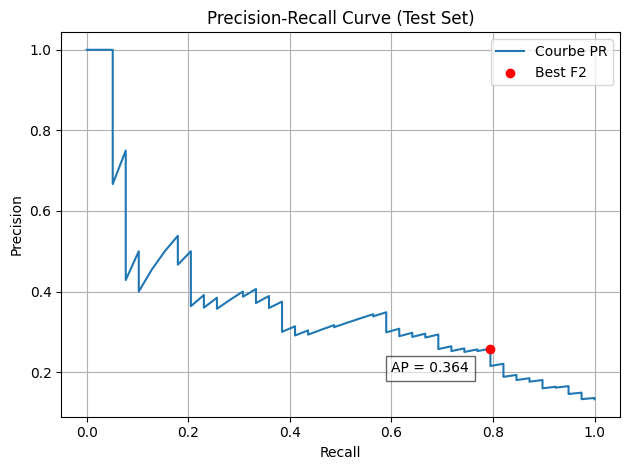

=== Classification Report - TEST ===
              precision    recall  f1-score   support

           0      0.887     0.953     0.919       255
           1      0.400     0.205     0.271        39

    accuracy                          0.854       294
   macro avg      0.643     0.579     0.595       294
weighted avg      0.822     0.854     0.833       294

=== Classification Report — TEST avec seuil optimal ===
              precision    recall  f1-score   support

           0      0.954     0.651     0.774       255
           1      0.258     0.795     0.390        39

    accuracy                          0.670       294
   macro avg      0.606     0.723     0.582       294
weighted avg      0.862     0.670     0.723       294



,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [33]:
modelisation(XGBClassifier(), amelioration_modele)

Learning rate set to 0.009286
0:	learn: 0.6873390	total: 57.8ms	remaining: 57.8s
1:	learn: 0.6814447	total: 58.8ms	remaining: 29.3s
2:	learn: 0.6742500	total: 59.5ms	remaining: 19.8s
3:	learn: 0.6671811	total: 60.3ms	remaining: 15s
4:	learn: 0.6604368	total: 61.2ms	remaining: 12.2s
5:	learn: 0.6542512	total: 62.1ms	remaining: 10.3s
6:	learn: 0.6493219	total: 62.9ms	remaining: 8.92s
7:	learn: 0.6418520	total: 63.6ms	remaining: 7.89s
8:	learn: 0.6354424	total: 65.4ms	remaining: 7.2s
9:	learn: 0.6279896	total: 66.9ms	remaining: 6.63s
10:	learn: 0.6223614	total: 68ms	remaining: 6.11s
11:	learn: 0.6169401	total: 68.8ms	remaining: 5.66s
12:	learn: 0.6098880	total: 70ms	remaining: 5.32s
13:	learn: 0.6054611	total: 70.8ms	remaining: 4.99s
14:	learn: 0.6007869	total: 71.6ms	remaining: 4.7s
15:	learn: 0.5958340	total: 72.4ms	remaining: 4.45s
16:	learn: 0.5898853	total: 73.3ms	remaining: 4.24s
17:	learn: 0.5850795	total: 74.1ms	remaining: 4.04s
18:	learn: 0.5795425	total: 75ms	remaining: 3.87s
19

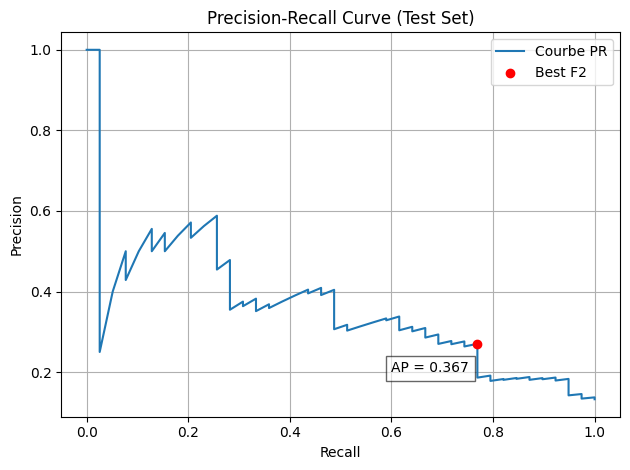

=== Classification Report - TEST ===
              precision    recall  f1-score   support

           0      0.886     0.976     0.929       255
           1      0.538     0.179     0.269        39

    accuracy                          0.871       294
   macro avg      0.712     0.578     0.599       294
weighted avg      0.840     0.871     0.842       294

=== Classification Report — TEST avec seuil optimal ===
              precision    recall  f1-score   support

           0      0.951     0.682     0.795       255
           1      0.270     0.769     0.400        39

    accuracy                          0.694       294
   macro avg      0.611     0.726     0.597       294
weighted avg      0.861     0.694     0.742       294



In [36]:
modelisation(CatBoostClassifier(), amelioration_modele)